In [5]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

In [13]:
import numpy as np
import time
import pandas as pd
import math
import matplotlib.pyplot as plt

import pybnb
from transformers import *

from generalized_dtw import Warp
from branch_and_bound_warped_pvar_sequential import BnBWarping

In [7]:
dist = 'eucl'

if dist == 'eucl':
    # Euclidean
    d = lambda a, b: (a-b)**2
    f_d = lambda DD, a, b: np.sqrt(DD**2 + d(a, b))
    final_operator = lambda x: np.sqrt(x)

elif dist == 'manh':
    # Manhattan
    d = lambda a, b : np.abs(a-b)
    f_d = lambda DD, a, b: DD + d(a,b)
    final_operator = lambda x: x
    
else:
    # Minkowksi
    d = lambda a, b : np.abs(a-b)
    f_d = lambda DD, a, b: max(DD, d(a,b))
    final_operator = lambda x: x

In [44]:
def white(steps, width, time=1.):
    mu, sigma = 0, math.sqrt(time / steps) 
    return np.random.normal(mu, sigma, (steps, width))

def brownian(steps, width, time=1.):
    path = np.zeros((steps + 1, width))
    np.cumsum(white(steps, width, time), axis=0, out=path[1:, :])
    return path

# Generate smooth sine wave

In [108]:
n_samples = 20
T = 2*np.pi

idx = np.linspace(0, T, n_samples)

X = np.sin(idx).reshape(-1, 1)

# Brownian perturbations

In [114]:
BM = brownian(n_samples-1, 1, T/5)

X_eps = X + BM

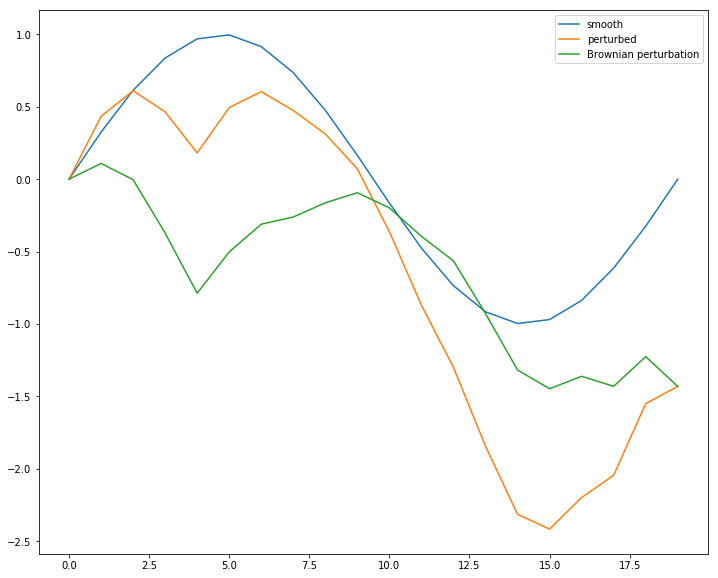

In [115]:
df = pd.DataFrame([X[:,0], X_eps[:,0], BM[:,0]], index=['smooth', 'perturbed', 'Brownian perturbation']).T.dropna()
df.plot(figsize=(12, 10))
plt.show()

# DTW

In [116]:
W = Warp(df.smooth.values, df.perturbed.values, d, f_d, final_operator, plot_2d=False)

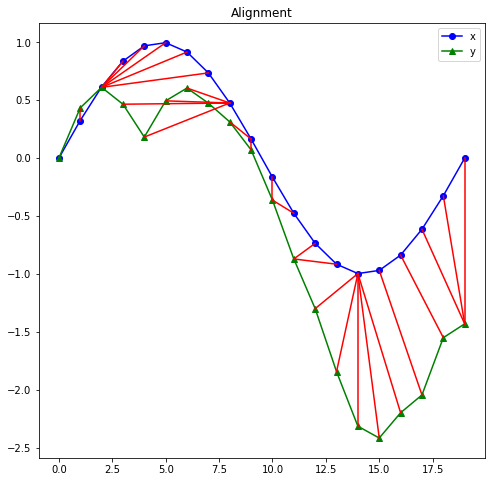

In [117]:
plt.figure(figsize=(8, 8))
W.plot_alignment()

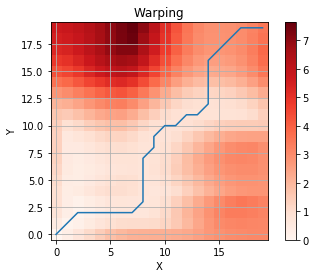

In [118]:
W.plot_lattice()

# Warped rough p-var distance

In [119]:
x = AddTime().fit_transform([df.smooth.values])[0]
y = AddTime().fit_transform([df.perturbed.values])[0]

In [ ]:
problem = BnBWarping(x=x, y=y, p=1.8, depth=2, norm='l1', root_node=(0, 0), bc=4,
                     plot_2d=True, pvar_dist_mem=None, cache_size=1024)

solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')

print('warped p-var: {:.2f}'.format(results.objective))
print('wall time: {:.2f} secs \n'.format(results.wall_time))

best_warp = results.best_node.state
print('best_warp: {} \n'.format(best_warp[1:]))
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()